## Regularization Part 1

In [1]:
import os
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x): # sigmoid activation
    return 1. / (1. + np.exp(-x))


def dSigmoid(x): # derivative of sigmoid
    s = sigmoid(x)
    return np.multiply(s, (1-s))


def relu(z): # rectified linear unit activation
    return np.maximum(0, z)


def dRelu(z): # derivative of relu
    return 1 * (z > 0)

# Student Coding step 3:
Add early stopping based on validation loss & patience in the model.fit function definition

In [3]:
class ANN:
    data = []
    layers = []
    inputWidth = 1
    outputWidth = 1

    class Layer:

        """class defining the elements of an ANN layer"""

        def __init__(self):
            self.w = []
            self.b = []
            self.nodecount = []
            self.activation_fcn = []
            self.activation_fcn_derivative = []
            self.orderNumber = []
            self.previous = None  # link to previous layer
            self.next = None  # link to next layer

        def set_weights(self, w, b):
            """set the weights and bias for the layer.  Layer weights should have dimesion: (thislayer_nodecount, previouslayer_nodecount)
            the dimension of the bias should be (thislayer_nodecount,1)"""
            self.w = w
            self.b = b
            return self
        
        def initialize_weights(self, seed=None):
            assert self.w.size > 0
            assert self.b.size > 0
            np.random.seed(seed)  
            self.w = np.random.normal(size=(self.w.shape))  # hidden weight matrix [rows = to, columns = from]
            self.b = np.random.normal(size=(self.b.shape))  # hidden biases (column vector)

        def set_activation(self, activation_fcn):
            self.activation_fcn = activation_fcn
            return self

        def set_activation_deriv(self, activation_fcn):
            if activation_fcn == sigmoid:
                self.activation_fcn_derivative = copy.deepcopy(dSigmoid)
            elif activation_fcn == relu:
                self.activation_fcn_derivative = copy.deepcopy(dRelu)
            else:
                self.activation_fcn_derivative = None
                
        def display_params(self):
            """displays the weights and biases of the layer (rows = to, colums = from)"""
            for outNum in range(self.w.shape[0]):
                print(self.w[outNum,:], "  ", self.b[outNum])

        def compute_pre_activation(self, inputs):
            net = np.dot(self.w, inputs) + self.b
            return net

        def compute_bias_gradient(self, gradient):
            g = np.mean(gradient, axis=1)[:, np.newaxis]  # no regularization
            return g

        def compute_weight_gradient(self, inputs, gradient):
            g = np.dot(gradient, inputs.T)
            return g

        def compute_activation(self, net):
            return self.activation_fcn(net)

        def compute_activation_derivative(self, net):
            return self.activation_fcn_derivative(net)

        def compute_activation_gradient(self, net, gradient):
            g = np.multiply(gradient, net)
            return g

        def compute_forward(self, inputs):
            """Returns layer ouput from input (shape = [nodeCount, input]) of the weighted input plus bias
            input shape must be [lastlayer_nodeCount, samples] or [featurecount, samplecount] """
            net = self.compute_pre_activation(self, inputs)
            layer_out = self.compute_activation(net)
            return layer_out

        def compute_layer_gradients(self, inputs, net, activation, gradient):
            """ computes the loss gradient with respect to desired output of the layer
            a set of desired targets is assumed to be matrix of shape [nodecount, samples]: SGD will have [nodecount,1]
            hidden_inputs is assumed to be a matrix of shape [hiddenNodeCount, samples]
            
            This follows algorithm 6.4 line by line in the book!
            
            """
            
            # f'(a(k))
            d_activation = self.compute_activation_derivative(net)  # derivative of sigmoid:  shape = [NodeCount, samples]
            
            # g <- g * f'(a(k))
            g_loss = self.compute_activation_gradient(d_activation, gradient)  # shape = [NodeCount, samples]  for outer layer
            
            # Delta_b(k) J = g (Take the mean across all 4 samples (batch))
            g_loss_b = self.compute_bias_gradient(g_loss)  # mean gradient with respect to BIAS, shape = [NodeCount, 1]
            
            # Delta w(k) J = g * h(k-1)
            g_loss_w = self.compute_weight_gradient(activation, g_loss)  # [1, 3]  Hidden layer outputs after activation
            
            # g <- W(k).T * g
            g_loss_backprop = np.dot(self.w.T, g_loss)  # gradient to propagate back, shape = [hiddenNodeCount,samples]
            
            return g_loss_w, g_loss_b, g_loss_backprop

        def update_Layer(self, weightUpdate, biasUpdate):
            self.w = self.w + weightUpdate
            self.b = self.b + biasUpdate

    def __init__(self):
        self.data = []
        self.layers = []
        self.inputWidth = 1
        self.outputWidth = 1

    def set_input_width(self, inputWidth):
        """defines the input layer width for the network"""
        self.inputWidth = inputWidth

    def add_layer(self, nodecount=1, activation_fcn=relu):
        """adds a layer to the neural network and returns the layer"""
        oldLayerCount = len(self.layers)
        thislayer = ANN.Layer()
        thislayer.orderNumber = oldLayerCount + 1
        if oldLayerCount > 0:  # other layers have been added already
            lastLayer = self.layers[-1]
            lastLayer.display_params()
            thislayer.previous = lastLayer
            lastLayer.next = thislayer
            layerInputSize = lastLayer.w.shape[0]
        else:  # this will be the first layer
            layerInputSize = self.inputWidth
            
        thislayer.w = np.zeros((nodecount, layerInputSize))  #[NODECOUNT,FROM]
        thislayer.b = np.zeros((nodecount, 1 )) #[NODECOUNT,FROM]
        thislayer.activation_fcn = activation_fcn
        thislayer.set_activation_deriv(activation_fcn)
        self.outputWidth = nodecount
        self.layers = self.layers + [thislayer]
        return thislayer
    
    def initialize(self, seed = None):
        """initialize weights & biases: overwrites current network parameters"""
        for layer in self.layers:
            layer.initialize_weights(seed)
    
    def summary(self):
        """displays a summary of the model"""
        tot_train_parameters = 0
        print("\n")
        print("Layer     Inshape     Outshape     Param #  ")
        print("================================")
        for lnum, layer in enumerate(self.layers):
            inshape = layer.w.shape[1]
            weightCount = layer.w.shape[0]*layer.w.shape[1]  #assume fully connected
            biasCount = layer.b.shape[0]
            thislayerparams = weightCount+biasCount
            tot_train_parameters += thislayerparams
            print("% 3d      % 3d          % 3d        %3d " %(lnum,inshape,biasCount,thislayerparams))
        print("================================")
        print("total trainable params: ",tot_train_parameters )
        
    def display_params(self):
        """displays the weights and biases of the network (rows = to, colums = from)"""
        print("\n")
        print("input width: ", self.inputWidth)
        for lnum, layer in enumerate(self.layers):
            print("Layer ",lnum)
            layer.display_params()
        print("output width: ", layer.w.shape[0])
                     
    def forwardPropagation(self, inputs):
        """Compute forward pass of two layer network
        inputs are assumed to be (shape=[sampleCount,featureCount])
        returns a matrix of raw outputs with one row of output per node (shape=[sampleCount, outputNodeCount])
        Internal matrices are shaped for efficiency to avoid internal transposes (columns hold observations/samples) """

        # inputs and outputs will be transposed for efficiency during forwardPropagation and untransposed before returning

        nets = []
        activations = []
        layer_input = inputs.T

        for lnum, layer in enumerate(self.layers):
            # inputs = inputs + inputs
            layer_net = layer.compute_pre_activation(layer_input)
            nets.append(layer_net)

            layer_out = layer.compute_activation(layer_net)
            activations.append(layer_out)

            layer_input = layer_out
        raw_output = layer_out.T
        return raw_output, inputs, nets, activations

    def backPropagation(self, inputs, desiredOutputs, learningRate):
        w_grads = []
        b_grads = []
        # store nets and activations for each layer
        raw_output, _, nets, activations = self.forwardPropagation(inputs)
        layer_desired_out = desiredOutputs

        # Note: This is only part of the gradient
        layer_grad = desiredOutputs - raw_output

        #  computation of full gradient handled inside the loop below
        for lnum, layer in reversed(list(enumerate(self.layers))):
            if lnum == 0:
                prev_layer_output = inputs.T
            else:
                prev_layer_output = activations[lnum - 1]
            if lnum == 1:
                w_grad, b_grad, loss_grad = layer.compute_layer_gradients(inputs[lnum], nets[lnum], prev_layer_output,
                                                                          layer_grad.T)
            else:
                w_grad, b_grad, loss_grad = layer.compute_layer_gradients(inputs[lnum], nets[lnum], prev_layer_output,
                                                                          layer_grad)
            layer.update_Layer(w_grad * learningRate, b_grad * learningRate)
            layer_grad = loss_grad

    def predict(self, X, threshold=0.5):
        """Compute predictions using forward propagation for single binary classification at threshold
        X is a standard dataFrame without biases (shape=[observationCount,featureCount])
        returns a standard column vector of binary predictions in {0,1}: (shape=[observationCount, 1])"""
        raw_predictions, net_inputs, net_lst, activation_lst = self.forwardPropagation(X)
        preds = raw_predictions > threshold
        return preds

    def compute_loss(self, inputs, desired_targets):
        """computes the (scalar) loss using MSE of a set of targets and sigmoid outputs
        inputs is assumed to be a matrix of shape [samples, features]
         desired_targets is assumed to be a matrix of shape [samples, 1]"""
        raw_outputs = self.forwardPropagation(inputs)[0]
        error = desired_targets - raw_outputs
        mse = np.dot(error.T, error) / error.size
        return mse

    def fit(self, tngInputs, tngTargets, valInputs, valTargets, learningRate, learningRateDecay,
            valPatience=5, tolerance=1e-2, maxEpochs = 100):
        """fit model to map tngInputs to tngTargets. If valPatience > 0 then use early stopping on valInputs & valTargets
        returns training loss history and val loss history """
        done = False
        tng_loss_history = []
        val_loss_history = []
        print("Training Model...")
        epoch = 0
        #get current val performance
        valPreds = self.predict(valInputs)
        prev_val_loss = np.asscalar(self.compute_loss(valInputs, valTargets))
        val_loss_history.append(prev_val_loss)
        val_epochs_nonimproved = 0
        
        improvement_delta = 0
        cur_val_loss = np.inf
        old_val_loss = np.inf
        
        while not done:
            epoch+=1
            if epoch>maxEpochs: 
                done = True
            learningRate = learningRate * learningRateDecay
            tngPreds = self.predict(tngInputs)
            tngCorrect = tngTargets == tngPreds
            curr_train_loss = np.asscalar(self.compute_loss(tngInputs, tngTargets))
            tng_loss_history.append(curr_train_loss)
            if curr_train_loss < tolerance:  #regular stopping
                done = True
            # run an epoch of backprop
            self.backPropagation(tngInputs, tngTargets, learningRate=learningRate)
            
            valPreds = self.predict(valInputs)
            old_val_loss = cur_val_loss
            cur_val_loss = np.asscalar(self.compute_loss(valInputs, valTargets))

            ############## STUDENT CODE #################
            # WRITE CODE TO IMPLEMENT EARLY STOPPING USING VAL LOSS IMPROVEMENT
            # if validation loss has not improved in patience epochs then stop
            
            if valPatience > 0:
                if cur_val_loss >= old_val_loss:
                    improvement_delta += 1
                
                    if improvement_delta == valPatience:
                        done = True
                
                else:
                    improvement_delta = 0

            ############ END STUDENT CODE ###############

            val_loss_history.append(cur_val_loss)
            
        print("Training Complete!")

        return tng_loss_history, val_loss_history

In [4]:
def makeDecisionBoundaryBool2(model, featureData, labelData, title):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''
    cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = model.predict(grid)  # get predictions
    z = preds.reshape(X.shape) > cutoff  # cutoff on predictions to return boolean output
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(np.asscalar(txt), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()


def show2dFunctionOutput(model_function, featureData, labelData, title):
    """display results of arbitrary model function on 2-input (x1,x2) , 1-output (z) graphs"""
    # cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    outputs, _, _, _ = model_function(grid)  # get predictions
    z = outputs.reshape(X.shape)  # reshape predictions for 2d representation
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(np.asscalar(txt), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    plt.show()

In [5]:
def get_input_output_data(gate='XOR'):
    """ Two dimensional inputs for logic gates

    Parameters
    ----------
    gate : str
        Must be either AND, OR, XOR

    Returns
    -------
    X : array-like, shape(samples, features)
        Two dim input for logic gates

    truth[gate] : array-like, shapes(samples, )
        The truth value for this logic gate

    """

    X = np.array([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

    truth = {
        'AND': np.array([0, 0, 0, 1]),
        'OR': np.array([0, 1, 1, 1]),
        'XOR': np.array([0, 1, 1, 0])
    }

    return X, truth[gate][:, np.newaxis]

In [6]:
def make_ANN_model(input_width = 2,
                   layer_widths = [3,1],
                   layer_activations = [sigmoid,sigmoid]):
    model = ANN()
    print(list(zip(layer_widths,layer_activations)))
    model.set_input_width(input_width)
    for lnum,(layerWidth,layerActivation) in enumerate(zip(layer_widths,layer_activations)):
        model.add_layer(nodecount = layerWidth, activation_fcn=layerActivation)
    model.initialize()
    return model

In [7]:
def train_ANN_model(model=None,
                    trainX = None, trainY = None,
                    valX=None,valY=None,
                    learning_rate=1.0,
                    lr_decay=0.999,
                    valPatience=0,
                    maxEpochs = 100):
    
    preds = model.predict(valX)
    correct = valY == preds
    print("BEFORE TRAINING (randomized weights)")
    model.display_params()
    print("\n")
    print("predictions: \n", preds)
    print("Predictions correct?: \n", correct)

    #fit(self, tngInputs, tngTargets, valInputs, valTargets, learningRate, learningRateDecay,
    #        valPatience=0, tolerance=1e-2, maxEpochs = 100)
    tng_loss_history,val_loss_history = model.fit(tngInputs=trainX, tngTargets=trainY, valInputs=valX, valTargets = valY,
                                                  learningRate=learning_rate, learningRateDecay=lr_decay, valPatience=valPatience,
                                                  tolerance=1e-1, maxEpochs=maxEpochs)

    preds = model.predict(valX)
    correct = valY == preds

    print("AFTER TRAINING (learned model weights)")
    model.display_params()

    print("\n")
    print("predictions: \n", preds)
    print("Predictions correct?: \n", correct)

    show2dFunctionOutput(model.forwardPropagation, X, Y, "Sigmoid Response of Network - student")
    makeDecisionBoundaryBool2(model, X, Y, "XOR predictions - student")

    plt.figure()
    plt.plot(tng_loss_history,'r')
    #plt.plot(val_loss_history, 'b')
    plt.xlabel("iteration")
    plt.ylabel("Loss (mse)")
    plt.title("Loss over iterations")
    plt.show() 

# Student coding step 1: 
Increase the capacity of the network

In [8]:
############## STUDENT CODE ##################

model = make_ANN_model(input_width = 2,
                   layer_widths = [5,1],  #number of nodes in each layer
                   layer_activations = [sigmoid,sigmoid])  #activations at each layer

######## END STUDENT CODE ####################

print("empty model info")
model.summary()

[(5, <function sigmoid at 0x000001A300257D08>), (1, <function sigmoid at 0x000001A300257D08>)]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #  
  0        2            5         15 
  1        5            1          6 
total trainable params:  21


BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[-0.41664062  0.39412951]    [-0.35205713]
[-0.26021863  1.05107844]    [0.0863409]
[-0.90719557 -0.05800154]    [-0.45334915]
[-1.29450363  0.13284289]    [1.58515597]
[-1.64997894 -0.63959227]    [-1.34508492]
Layer  1
[ 0.06917851 -0.76002816  1.56549434  1.39504029  0.53562572]    [0.63123889]
output width:  1


predictions: 
 [[ True]
 [ True]
 [ True]
 [ True]]
Predictions correct?: 
 [[False]
 [ True]
 [ True]
 [False]]
Training Model...
Training Complete!
AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[-0.4852825   0.13668731]    [-0.3337102]
[-2.60573252  3.22591401]    [1.04805467]
[-3.15437413  2.63106635]    [-1.2809516]
[-0.96485248 -0.44598162]    [1.66684959]
[-1.91317948 -1.20082513]    [-1.20414726]
Layer  1
[-0.05397472 -3.21318331  3.65969782  0.87437584 -1.43717736]    [0.60506459]
output width:  1


predictions: 
 [[False]
 [ True]
 [ True]
 [False]]
Predictions correct?: 
 [[ True]


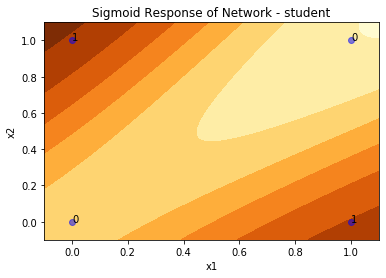

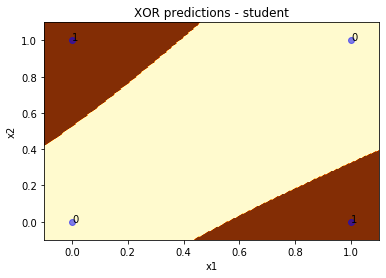

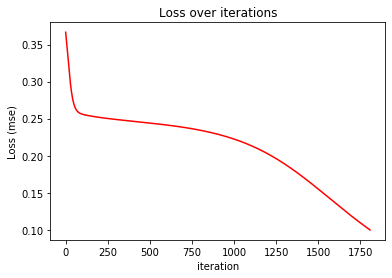

In [9]:
X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

train_ANN_model(model,trainX,trainY,valX,valY,
                learning_rate=0.1,lr_decay=1.0,
                valPatience = 5, maxEpochs = 10000)

# Student Code 2
Create augmented training dataset. Add small amounts of random gaussian noise to X datapoints, but keep the same Y labels

In [10]:
def generateAugmentedTrainData(X,Y,augCount=100):
    """starting with original datapoints X and labels Y, return new augmented datapoints of size augCount"""
   
    ##### STUDENT CODE FOR DATA AUGMENTATION #############
    # make a larger dataset in which you
    # add a small random perturbation to the features of each datapoint
    
    idx = np.random.randint(X.shape[0], size=augCount)
    noise = np.random.normal(scale=0.1, size=(augCount, X.shape[1]))
    return X[idx] + noise, Y[idx]

# # ----- loop method
#     xtrain = []
#     ytrain = []

#     for i in range(augCount):
#         idx = np.random.randint(0, 4)
        
#         ytrain.append(Y[idx])
#         xtrain.append([
#             X[idx][0] + np.random.normal(0, 0.1),
#             X[idx][1] + np.random.normal(0, 0.1)
#         ])

#     return xtrain,ytrain

    ############# END STUDENT CODE #######################

BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 0.16276839 -0.5255222 ]    [-1.44657882]
[-0.06784656 -1.16865173]    [0.23725291]
[0.18790996 1.51495595]    [-0.19534178]
[-0.19409912  0.29038123]    [-0.0747313]
[-0.01192992 -0.37948788]    [-0.14657327]
Layer  1
[-1.03238171  0.48633866  0.4989574   1.24403651  2.45519049]    [0.08289224]
output width:  1


predictions: 
 [[ True]
 [ True]
 [ True]
 [ True]]
Predictions correct?: 
 [[False]
 [ True]
 [ True]
 [False]]
Training Model...
Training Complete!
AFTER TRAINING (learned model weights)


input width:  2
Layer  0
[-1.61878687 -1.94827791]    [-1.1632543]
[-2.84884371 -3.33161602]    [0.27151456]
[-0.09377114  1.65718915]    [-0.15625567]
[-2.7218606   1.19396772]    [-0.32975359]
[ 1.53600055 -3.08952958]    [-0.79590514]
Layer  1
[-2.27461478 -3.3394087  -0.77384186  2.69062882  2.92977461]    [-0.40177557]
output width:  1


predictions: 
 [[False]
 [ True]
 [ True]
 [False]]
Predictions correct?: 
 [[ True

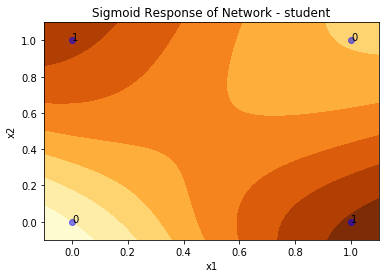

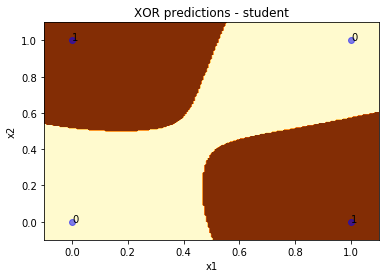

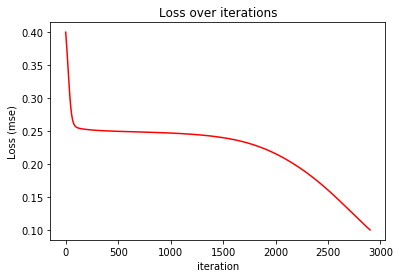

In [11]:
xtrain,ytrain = generateAugmentedTrainData(X,Y,1000)

valX,valY=X,Y

model.initialize()

train_ANN_model(model,trainX,trainY,valX,valY,
                learning_rate=0.1,lr_decay=1.0,
                valPatience = 5, maxEpochs = 10000)